**membangun model prediksi konsumsi listrik harian berbasis data cuaca dan waktu.**

**Langkah 1: Import Library & Load Data**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Load dataset
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')


**Langkah 2: Eksplorasi Data Awal**

In [ ]:
print(df_train.shape)
print(df_train.columns)
print(df_train.head())
print(df_train.describe())
print(df_train.isnull().sum())


(11688, 15)
Index(['ID', 'date', 'cluster_id', 'electricity_consumption',
       'temperature_2m_max', 'temperature_2m_min', 'apparent_temperature_max',
       'apparent_temperature_min', 'sunshine_duration', 'daylight_duration',
       'wind_speed_10m_max', 'wind_gusts_10m_max',
       'wind_direction_10m_dominant', 'shortwave_radiation_sum',
       'et0_fao_evapotranspiration'],
      dtype='object')
                     ID        date cluster_id  electricity_consumption  \
0  cluster_1_2014-01-01  2014-01-01  cluster_1                  358.032   
1  cluster_2_2014-01-01  2014-01-01  cluster_2                  548.247   
2  cluster_3_2014-01-01  2014-01-01  cluster_3                  758.303   
3  cluster_4_2014-01-01  2014-01-01  cluster_4                 1072.077   
4  cluster_1_2014-01-02  2014-01-02  cluster_1                  386.908   

   temperature_2m_max  temperature_2m_min  apparent_temperature_max  \
0                10.8                 4.2                       5.5   
1

In [ ]:
target_col = 'electricity_consumption'


**Langkah 3: Pra-pemrosesan Data**

In [ ]:
df_train['date'] = pd.to_datetime(df_train['date'])
df_test['date'] = pd.to_datetime(df_test['date'])

# Encode cluster_id
df_train['cluster_id'] = df_train['cluster_id'].astype('category').cat.codes
df_test['cluster_id'] = df_test['cluster_id'].astype('category').cat.codes


**Langkah 4: Feature Selection / Engineering**

In [ ]:
df_train['temp_range'] = df_train['temperature_2m_max'] - df_train['temperature_2m_min']
df_test['temp_range'] = df_test['temperature_2m_max'] - df_test['temperature_2m_min']


**Langkah 5: Split Data untuk Validasi**

In [ ]:
X = df_train.drop(columns=['ID', 'date', 'electricity_consumption'])  # hapus target dan non-fitur
y = df_train['electricity_consumption']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


**Langkah 6: Modeling (Baseline)**

In [ ]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
print("RMSE:", rmse)


RMSE: 51.115535223252905


In [ ]:
df_train['electricity_consumption'].describe()

,electricity_consumption
count,11688.000000
mean,642.313328
std,287.673473
min,207.472000
25%,414.376000
50%,602.672000
75%,836.034500
max,1658.348000


In [ ]:
# Rentang suhu dan suhu nyata
df_train['temp_range'] = df_train['temperature_2m_max'] - df_train['temperature_2m_min']
df_test['temp_range'] = df_test['temperature_2m_max'] - df_test['temperature_2m_min']

df_train['apparent_range'] = df_train['apparent_temperature_max'] - df_train['apparent_temperature_min']
df_test['apparent_range'] = df_test['apparent_temperature_max'] - df_test['apparent_temperature_min']

# Perbandingan durasi sinar matahari terhadap siang hari
df_train['sun_ratio'] = df_train['sunshine_duration'] / (df_train['daylight_duration'] + 1e-6)
df_test['sun_ratio'] = df_test['sunshine_duration'] / (df_test['daylight_duration'] + 1e-6)

# Hari keberapa dalam tahun
df_train['day_of_year'] = df_train['date'].dt.dayofyear
df_test['day_of_year'] = df_test['date'].dt.dayofyear


In [ ]:
# Tentukan fitur yang akan digunakan untuk pelatihan model
# Hapus kolom non-fitur seperti ID, date, dan target
feature_cols = df_train.columns.difference(['ID', 'date', 'electricity_consumption'])  # pastikan nama target benar

X = df_train[feature_cols]
y = df_train['electricity_consumption']

X_test = df_test[feature_cols]


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

xgb = XGBRegressor(n_estimators=200, learning_rate=0.05, random_state=42)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_val)
rmse_xgb = np.sqrt(mean_squared_error(y_val, y_pred_xgb))
print("RMSE (XGBoost + FE):", rmse_xgb)


RMSE (XGBoost + FE): 47.831846009599154


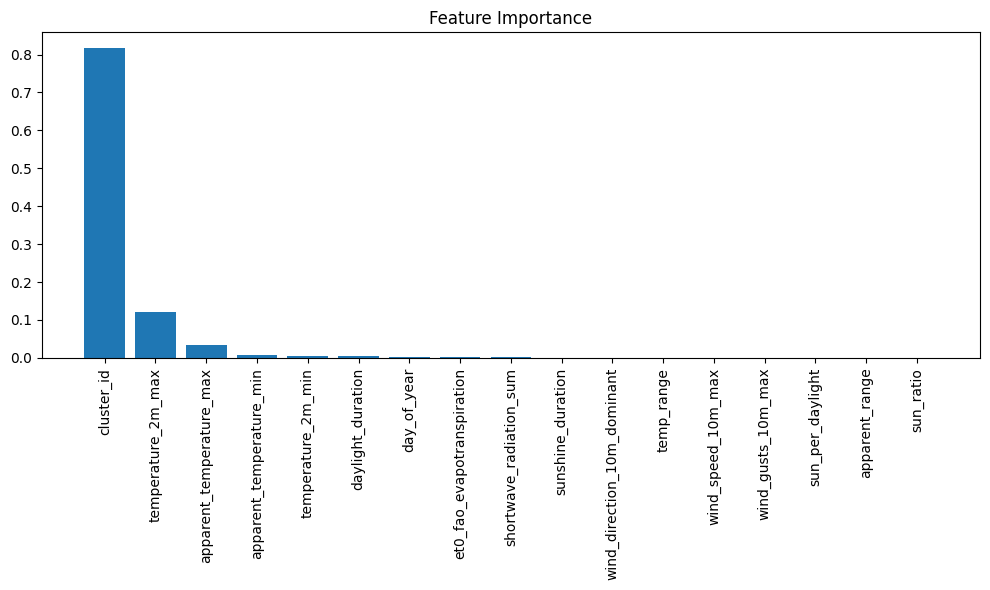

In [ ]:
import matplotlib.pyplot as plt

importances = xgb.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_train.columns[indices]

plt.figure(figsize=(10,6))
plt.title("Feature Importance")
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), features, rotation=90)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_model = XGBRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=20,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 1.0}


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

best_model = random_search.best_estimator_

y_pred_best = best_model.predict(X_val)
rmse_best = np.sqrt(mean_squared_error(y_val, y_pred_best))
print("RMSE (XGBoost Tuned):", rmse_best)


RMSE (XGBoost Tuned): 47.58421930308592


In [ ]:
print("Perbedaan fitur antara X_train dan X_test:")
print(set(X_train.columns) - set(X_test.columns))


Perbedaan fitur antara X_train dan X_test:
set()


In [ ]:
print(submission['electricity_consumption'].describe())


count    3400.000000
mean      650.120605
std       286.853821
min       233.842804
25%       418.896408
50%       605.468689
75%       844.314499
max      1545.961182
Name: electricity_consumption, dtype: float64


In [ ]:
# Pastikan kolom 'date' sudah dalam format datetime
df_train['date'] = pd.to_datetime(df_train['date'])
df_test['date'] = pd.to_datetime(df_test['date'])

# Ekstrak komponen waktu
df_train['month'] = df_train['date'].dt.month
df_test['month'] = df_test['date'].dt.month

df_train['is_peak_month'] = df_train['month'].isin([6, 7, 8]).astype(int)
df_test['is_peak_month'] = df_test['month'].isin([6, 7, 8]).astype(int)

df_train['dayofweek'] = df_train['date'].dt.dayofweek  # 0 = Senin, 6 = Minggu
df_test['dayofweek'] = df_test['date'].dt.dayofweek

# Weekend flag
df_train['is_weekend'] = df_train['dayofweek'].isin([5, 6]).astype(int)
df_test['is_weekend'] = df_test['dayofweek'].isin([5, 6]).astype(int)


In [ ]:
df_train['wind_temp_interaction'] = df_train['wind_speed_10m_max'] * df_train['temperature_2m_max']
df_test['wind_temp_interaction'] = df_test['wind_speed_10m_max'] * df_test['temperature_2m_max']


In [ ]:
# Pastikan target tidak ikut masuk ke fitur
feature_cols = df_train.columns.difference(['ID', 'date', 'electricity_consumption'])

X = df_train[feature_cols]
y = df_train['electricity_consumption']
X_test = df_test[feature_cols]


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=1.0,
    random_state=42
)

model.fit(X_train, y_train)

# Prediksi di data validasi
y_pred = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print("📉 RMSE after adding seasonal & interaction features:", rmse)


📉 RMSE after adding seasonal & interaction features: 28.443640413351847


In [ ]:
test_pred = model.predict(X_test)

submission_v2 = pd.DataFrame({
    'ID': df_test['ID'],
    'electricity_consumption': test_pred
})

submission_v2.to_csv('submission_v2.csv', index=False)
print(" File 'submission_v2.csv' berhasil disimpan!")


 File 'submission_v2.csv' berhasil disimpan!


In [ ]:
# Tambah awal bulan
df_train['is_month_start'] = (df_train['date'].dt.day <= 3).astype(int)
df_test['is_month_start'] = (df_test['date'].dt.day <= 3).astype(int)

# Tambah radiasi per jam (intensitas cahaya matahari)
df_train['radiation_per_hour'] = df_train['shortwave_radiation_sum'] / ((df_train['daylight_duration'] / 3600) + 1e-6)
df_test['radiation_per_hour'] = df_test['shortwave_radiation_sum'] / ((df_test['daylight_duration'] / 3600) + 1e-6)

# Tambah interaksi radiasi & suhu
df_train['temp_radiation'] = df_train['temperature_2m_max'] * df_train['shortwave_radiation_sum']
df_test['temp_radiation'] = df_test['temperature_2m_max'] * df_test['shortwave_radiation_sum']

In [ ]:
from sklearn.model_selection import train_test_split

feature_cols = df_train.columns.difference(['ID', 'date', 'electricity_consumption'])

X = df_train[feature_cols]
y = df_train['electricity_consumption']
X_test = df_test[feature_cols]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Model 1: XGBoost
xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=1.0,
    random_state=42
)
xgb_model.fit(X_train, y_train)
xgb_val_pred = xgb_model.predict(X_val)

# Model 2: Random Forest
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)
rf_val_pred = rf_model.predict(X_val)

# Ensemble
val_pred_ensemble = 0.6 * xgb_val_pred + 0.4 * rf_val_pred
rmse_ensemble = np.sqrt(mean_squared_error(y_val, val_pred_ensemble))
print("📉 RMSE (Ensemble - val):", rmse_ensemble)


📉 RMSE (Ensemble - val): 28.860649357379494


In [ ]:
xgb_test_pred = xgb_model.predict(X_test)
rf_test_pred = rf_model.predict(X_test)
test_pred_ensemble = 0.6 * xgb_test_pred + 0.4 * rf_test_pred

# Clipping ke rentang konsumsi di data training
test_pred_ensemble = np.clip(test_pred_ensemble, 250, 1650)

submission = pd.DataFrame({
    'ID': df_test['ID'],
    'electricity_consumption': test_pred_ensemble
})
submission.to_csv('submission_ensemble_v3.csv', index=False)
print("File submission_ensemble_v3.csv berhasil dibuat!")


File submission_ensemble_v3.csv berhasil dibuat!


In [ ]:
# Loop per cluster
for cluster in df_train['cluster_id'].unique():
    train_cluster = df_train[df_train['cluster_id'] == cluster]
    test_cluster = df_test[df_test['cluster_id'] == cluster]

    # Train & predict seperti biasa per cluster...


In [ ]:
df_train = df_train.sort_values(['cluster_id', 'date'])
df_train['temp_avg_3'] = df_train.groupby('cluster_id')['temperature_2m_max'].transform(lambda x: x.rolling(3, min_periods=1).mean())
# Lakukan juga ke df_test (pakai concat jika perlu)


In [ ]:
# Gabung dulu
df_all = pd.concat([df_train, df_test], axis=0)
df_all = df_all.sort_values(['cluster_id', 'date'])

# Rolling feature suhu rata-rata 3 hari
df_all['temp_avg_3'] = df_all.groupby('cluster_id')['temperature_2m_max'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)

# Pisahkan kembali
df_train = df_all[df_all['electricity_consumption'].notnull()].copy()
df_test = df_all[df_all['electricity_consumption'].isnull()].copy()


In [ ]:
# Rata-rata kelembapan (kalau ada) atau radiasi
df_all['radiation_avg_3'] = df_all.groupby('cluster_id')['shortwave_radiation_sum'].transform(
    lambda x: x.rolling(3, min_periods=1).mean()
)

# Rolling suhu minimum atau apparent temp juga bisa
df_all['apparent_temp_avg_3'] = df_all.groupby('cluster_id')['apparent_temperature_max'].transform(
    lambda x: x.rolling(3, min_periods=1).mean()
)


In [ ]:
feature_cols = df_train.columns.difference(['ID', 'date', 'electricity_consumption'])

X = df_train[feature_cols]
y = df_train['electricity_consumption']
X_test = df_test[feature_cols]

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=1.0,
    random_state=42
)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

from sklearn.metrics import mean_squared_error
import numpy as np

mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
print("📉 RMSE after rolling feature:", rmse)



📉 RMSE after rolling feature: 26.609937934542277


In [ ]:
test_pred = model.predict(X_test)

# Clipping agar tetap dalam rentang realistis seperti data training
test_pred = np.clip(test_pred, 250, 1650)

submission = pd.DataFrame({
    'ID': df_test['ID'],
    'electricity_consumption': test_pred
})
submission.to_csv('submission_rolling_v4.csv', index=False)

print("✅ Submission 'submission_rolling_v4.csv' berhasil dibuat!")



✅ Submission 'submission_rolling_v4.csv' berhasil dibuat!
